# 01. Outlier detection

WARNING 
The count data used here are tpm

## 01.01 Reformat data 

In [1]:
# Define libraries
import pandas as pd
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
# Define libraries
path ="/data/projects/2024/duszka/NB_project/data/results_counts_raw_tpm_ann/"
file ="Galaxy3603-Column_Join_count_data_tpm.tsv"
NB_ids_file = "/data/projects/2024/duszka/NB_project/out/tmp/NB_clean_ids.txt"

In [3]:
#Lioad files
counts = pd.read_csv(f"{path}{file}", sep = "\t")
NB_ids_df = pd.read_csv(NB_ids_file, sep="\t")

In [30]:
NB_ids_df.columns

Index(['SampleID', 'mouseID', 'group', 'subgroup', 'source', 'sequencingID',
       'sample_type'],
      dtype='object')

In [4]:
NB_ids_df["sample_type"] = NB_ids_df["group"] + "." +  NB_ids_df["subgroup"] 

In [5]:
#Format column names 
counts.rename(columns=lambda x: x.split('_')[0], inplace=True)

In [6]:
# Get sequencingID from Samples from NB experiment 
NB_ids_list = NB_ids_df["sequencingID"].to_list()
# Into string every sequencingID
NB_ids_list = [str(num) for num in NB_ids_list]

In [7]:
#Filter all counts to from Samples from NB experiment 
counts_NB_samples = counts.filter(items=NB_ids_list)

In [8]:
# Filter DataFrame to include only samples with source=="intestine"
intestine_samples = NB_ids_df[NB_ids_df["source"] == "Intestine"]
liver_samples = NB_ids_df[NB_ids_df["source"] == "Liver"]

In [9]:
# Extract sequenginID as a list from the filtered DataFrame
intestine_samples_sequengingID = intestine_samples["sequencingID"].tolist()
intestine_samples_sequengingID= [str(num) for num in intestine_samples_sequengingID]

liver_samples_sequengingID = liver_samples["sequencingID"].tolist()
liver_samples_sequengingID= [str(num) for num in liver_samples_sequengingID]

#Filter all counts from Samples from NB experiment from specific source 
counts_NB_samples_intestine = counts.filter(items=intestine_samples_sequengingID)
counts_NB_samples_liver = counts.filter(items=liver_samples_sequengingID)

In [10]:
df_intestine = counts_NB_samples_intestine
df_liver = counts_NB_samples_liver

In [24]:
# Sum the counts across samples for each gene
gene_sums = df_intestine.sum(axis=1)
# Sort genes based on their summed counts in descending order
sorted_genes = gene_sums.sort_values(ascending=False)
top_1500_genes = sorted_genes.head(1500)
#Filter count matrix for the top 1500 h.e. genes 
counts_matrix = df_intestine.loc[top_1500_genes.index]

# Transpose the counts matrix so that samples become rows
counts_matrix_transposed = counts_matrix.transpose()

counts_matrix_transposed["sequencingID"] = counts_matrix_transposed.index

counts_matrix_transposed.reset_index(inplace=True)

counts_matrix_metadata = pd.concat([counts_matrix_transposed, NB_ids_df[NB_ids_df["source"]=="Intestine"]],axis=1)
counts_matrix_metadata = counts_matrix_metadata.loc[:,~counts_matrix_metadata.columns.duplicated()].copy() #remove duplicate columns
counts_matrix_metadata.to_csv("counts_matrix_metadata_intestine.csv")

In [25]:
del counts_matrix
del counts_matrix_transposed
del counts_matrix_metadata

In [27]:
# Sum the counts across samples for each gene
gene_sums = df_liver.sum(axis=1)
# Sort genes based on their summed counts in descending order
sorted_genes = gene_sums.sort_values(ascending=False)
top_1500_genes = sorted_genes.head(1500)
#Filter count matrix for the top 1500 h.e. genes 
counts_matrix = df_liver.loc[top_1500_genes.index]
# Transpose the counts matrix so that samples become rows
counts_matrix_transposed = counts_matrix.transpose()
counts_matrix_transposed["sequencingID"] = counts_matrix_transposed.index
counts_matrix_transposed.reset_index(inplace=True)
NB_ids_df_liver = NB_ids_df[NB_ids_df["source"]=="Liver"]
NB_ids_df_liver.reset_index(inplace=True)
counts_matrix_metadata = pd.concat([counts_matrix_transposed, NB_ids_df_liver],axis=1)
counts_matrix_metadata = counts_matrix_metadata.loc[:,~counts_matrix_metadata.columns.duplicated()].copy() #remove duplicate columns
counts_matrix_metadata.to_csv("counts_matrix_metadata_liver.csv")

## 01.02 Follow up analysis in R 
- The generated count_matrix csv for liver and intestine are analyzed in R (outlier_detection.R) where  PCA and outliers for both intestive and liver independetly are computed.
- To consider a sample outlier, distance to the centroid is calculated and threshold of 3 standard deviation is used.
- The same analysis is done in Python here below

## 01.03 Calculate outliers

In [19]:
# Store DataFrames in a list
dataframes = [counts_NB_samples_intestine, counts_NB_samples_liver]
source = ["intestine","liver"]

intestine
Outlier sample names:
Index([], dtype='object')


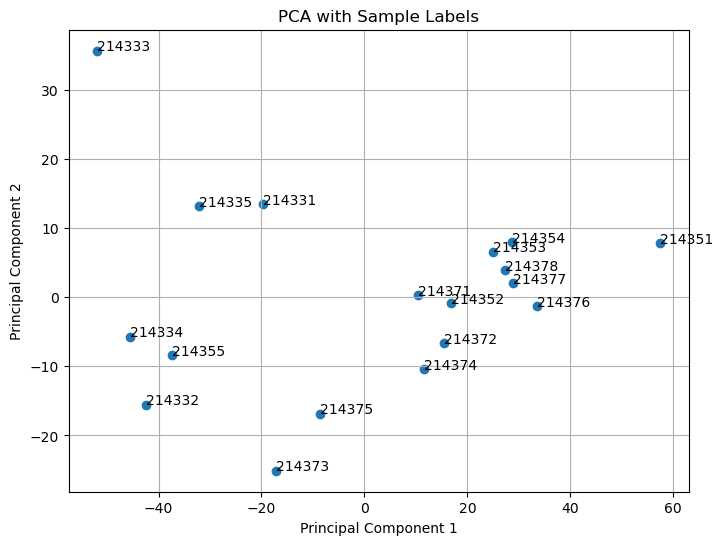

liver
Outlier sample names:
Index([], dtype='object')


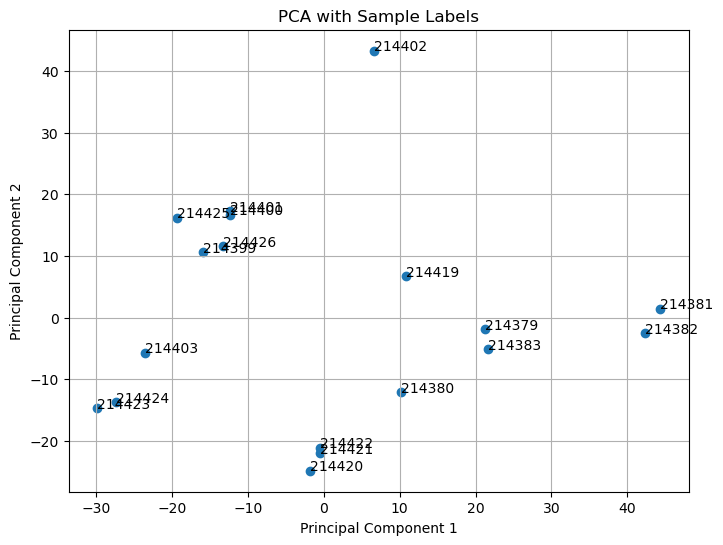

In [20]:
# Iterate over the list of DataFrames
for i, df in enumerate(dataframes, start=1):
    print(source[i-1])
    # Get top 1500 highly expressed genes

    # Sum the counts across samples for each gene
    gene_sums = df.sum(axis=1)
    # Sort genes based on their summed counts in descending order
    sorted_genes = gene_sums.sort_values(ascending=False)
    top_1500_genes = sorted_genes.head(1500)
    #Filter count matrix for the top 1500 h.e. genes 
    counts_matrix = df.loc[top_1500_genes.index]
    
    # Transpose the counts matrix so that samples become rows
    counts_matrix_transposed = counts_matrix.transpose()
    
    # Perform PCA
    pca = PCA(n_components=2)  # Specify the number of components you want to keep
    counts_matrix_standardized = StandardScaler().fit_transform(counts_matrix_transposed)  # Standardize the data
    pca_result = pca.fit_transform(counts_matrix_standardized)
    
    # Calculate the centroid of the PCA-transformed data
    centroid = pca_result.mean(axis=0)
    
    # Calculate the standard deviation of the PCA-transformed data
    std_deviation = pca_result.std(axis=0)
    
    # Calculate the distances of each sample from the centroid in the PCA-transformed space
    sample_distances = ((pca_result - centroid) / std_deviation).sum(axis=1)
    
    # Set a threshold for outlier detection (3 standard deviations away from the centroid)
    threshold = 3
    
    # Identify outlier samples
    outlier_sample_names = counts_matrix_transposed.index[abs(sample_distances) > threshold]
    
    print("Outlier sample names:")
    print(outlier_sample_names)

    # Plot PCA results
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1])
    
    # Annotate each point with sample label
    for i, sample_label in enumerate(counts_matrix_transposed.index):
        plt.annotate(sample_label, (pca_result[i, 0], pca_result[i, 1]))

    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA with Sample Labels')
    plt.grid(True)
    plt.show()

No outlier are detected for liver not for intestine